# Unit 7: Data Mining and Ethics

## Lab Objective
To examine ethical aspects of data mining including **privacy**, **fairness**, and **transparency**.

## Background Theory

### 1. Privacy and Security
- **Anonymization**: Removing personally identifiable information (PII)
- **Encryption**: Protecting data during storage and transmission
- **Consent**: Obtaining informed permission for data use

### 2. Social Impact
- **Discrimination**: Models can perpetuate historical biases
- **Bias in Models**: Algorithms may produce unfair outcomes for certain groups

### 3. Accountability
- **Transparency**: Clear documentation of model decisions
- **Explainability**: Understanding why models make specific predictions
- **Auditing**: Regular checks for fairness and accuracy

### 4. Sources of Bias
- **Data Collection Bias**: Non-representative sampling
- **Historical Bias**: Past discrimination encoded in data
- **Measurement Bias**: Flawed proxy variables
- **Labeling Bias**: Subjective or inconsistent annotations
- **Algorithmic Bias**: Model amplifies existing disparities

---
## Part 1: Import Libraries and Setup

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             precision_score, recall_score, f1_score)

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


---
## Part 2: Creating a Biased Dataset

We'll create a synthetic dataset that simulates a **loan approval system** with embedded historical bias against certain demographic groups. This demonstrates how real-world biases can be encoded in data.

In [2]:
# Create a synthetic biased loan approval dataset
np.random.seed(42)
n_samples = 2000

# Generate features
data = {
    'age': np.random.randint(22, 65, n_samples),
    'income': np.random.normal(55000, 20000, n_samples).clip(20000, 150000),
    'credit_score': np.random.normal(680, 80, n_samples).clip(300, 850),
    'employment_years': np.random.randint(0, 30, n_samples),
    'loan_amount': np.random.normal(25000, 15000, n_samples).clip(5000, 100000),
    'gender': np.random.choice(['Male', 'Female'], n_samples, p=[0.5, 0.5]),
    'race': np.random.choice(['Group_A', 'Group_B'], n_samples, p=[0.6, 0.4]),
}

df_biased = pd.DataFrame(data)

# Create a fair baseline approval (based only on financial factors)
df_biased['debt_to_income'] = df_biased['loan_amount'] / df_biased['income']

# Fair approval probability based on legitimate factors
fair_score = (
    (df_biased['credit_score'] - 300) / 550 * 0.4 +  # Credit score contribution
    (df_biased['income'] - 20000) / 130000 * 0.3 +    # Income contribution
    (df_biased['employment_years'] / 30) * 0.2 +       # Employment stability
    (1 - df_biased['debt_to_income'].clip(0, 1)) * 0.1  # Debt ratio
)

# INJECT BIAS: Reduce approval probability for certain groups
bias_penalty = np.where(df_biased['race'] == 'Group_B', -0.15, 0)  # Race bias
bias_penalty += np.where(df_biased['gender'] == 'Female', -0.08, 0)  # Gender bias

biased_score = (fair_score + bias_penalty).clip(0, 1)

# Generate biased labels
df_biased['approved_biased'] = (biased_score > 0.45).astype(int)

# Generate fair labels (what approval SHOULD be without bias)
df_biased['approved_fair'] = (fair_score > 0.45).astype(int)

print("Biased Loan Approval Dataset Created")
print(f"Total samples: {len(df_biased)}")
print(f"\nDataset shape: {df_biased.shape}")
df_biased.head(10)

Biased Loan Approval Dataset Created
Total samples: 2000

Dataset shape: (2000, 10)


,age,income,credit_score,employment_years,loan_amount,gender,race,debt_to_income,approved_biased,approved_fair
0,60,66895.086833,672.270106,28,9432.724694,Male,Group_A,0.141008,1,1
1,50,72068.311176,646.722646,3,47171.015883,Female,Group_A,0.654532,0,0
2,36,70178.571796,604.340315,4,20721.545262,Female,Group_B,0.295269,0,0
3,64,60623.828479,728.659695,25,8848.939696,Female,Group_A,0.145965,1,1
4,29,57084.022079,574.629446,20,27837.636078,Female,Group_B,0.487661,0,1
5,42,53748.137442,742.082233,16,10704.412627,Male,Group_B,0.199159,0,1
6,60,39920.708223,599.822638,21,25515.576415,Female,Group_A,0.639156,0,0
7,40,49386.498463,619.805181,28,16336.847026,Female,Group_B,0.330796,0,1
8,44,21140.863716,562.657185,24,39176.099018,Female,Group_A,1.853098,0,0
9,32,53033.207464,639.887828,1,27051.244149,Male,Group_A,0.510081,0,0


---
## Part 3: Analyzing Bias in the Dataset

Let's examine how the biased approval rates differ across demographic groups.

In [3]:
# Analyze approval rates by demographic groups
print("=" * 70)
print("APPROVAL RATE ANALYSIS BY DEMOGRAPHIC GROUPS")
print("=" * 70)

# By Race
print("\n📊 Approval Rates by Race:")
race_analysis = df_biased.groupby('race').agg({
    'approved_biased': ['sum', 'count', 'mean'],
    'approved_fair': 'mean',
    'credit_score': 'mean',
    'income': 'mean'
}).round(3)
race_analysis.columns = ['Approved (Biased)', 'Total', 'Biased Rate', 'Fair Rate', 'Avg Credit Score', 'Avg Income']
print(race_analysis)

# By Gender
print("\n📊 Approval Rates by Gender:")
gender_analysis = df_biased.groupby('gender').agg({
    'approved_biased': ['sum', 'count', 'mean'],
    'approved_fair': 'mean',
    'credit_score': 'mean',
    'income': 'mean'
}).round(3)
gender_analysis.columns = ['Approved (Biased)', 'Total', 'Biased Rate', 'Fair Rate', 'Avg Credit Score', 'Avg Income']
print(gender_analysis)

# By Race AND Gender (intersectional analysis)
print("\n📊 Intersectional Analysis (Race × Gender):")
intersect_analysis = df_biased.groupby(['race', 'gender']).agg({
    'approved_biased': 'mean',
    'approved_fair': 'mean'
}).round(3)
intersect_analysis.columns = ['Biased Approval Rate', 'Fair Approval Rate']
print(intersect_analysis)

APPROVAL RATE ANALYSIS BY DEMOGRAPHIC GROUPS

📊 Approval Rates by Race:
         Approved (Biased)  Total  Biased Rate  Fair Rate  Avg Credit Score  \
race                                                                          
Group_A                647   1206        0.536      0.683           676.966   
Group_B                 99    794        0.125      0.686           679.780   

         Avg Income  
race                 
Group_A   55969.469  
Group_B   54854.210  

📊 Approval Rates by Gender:
        Approved (Biased)  Total  Biased Rate  Fair Rate  Avg Credit Score  \
gender                                                                       
Female                244    984        0.248      0.690           679.078   
Male                  502   1016        0.494      0.679           677.119   

        Avg Income  
gender              
Female   55118.811  
Male     55921.764  

📊 Intersectional Analysis (Race × Gender):
                Biased Approval Rate  Fair Approval R

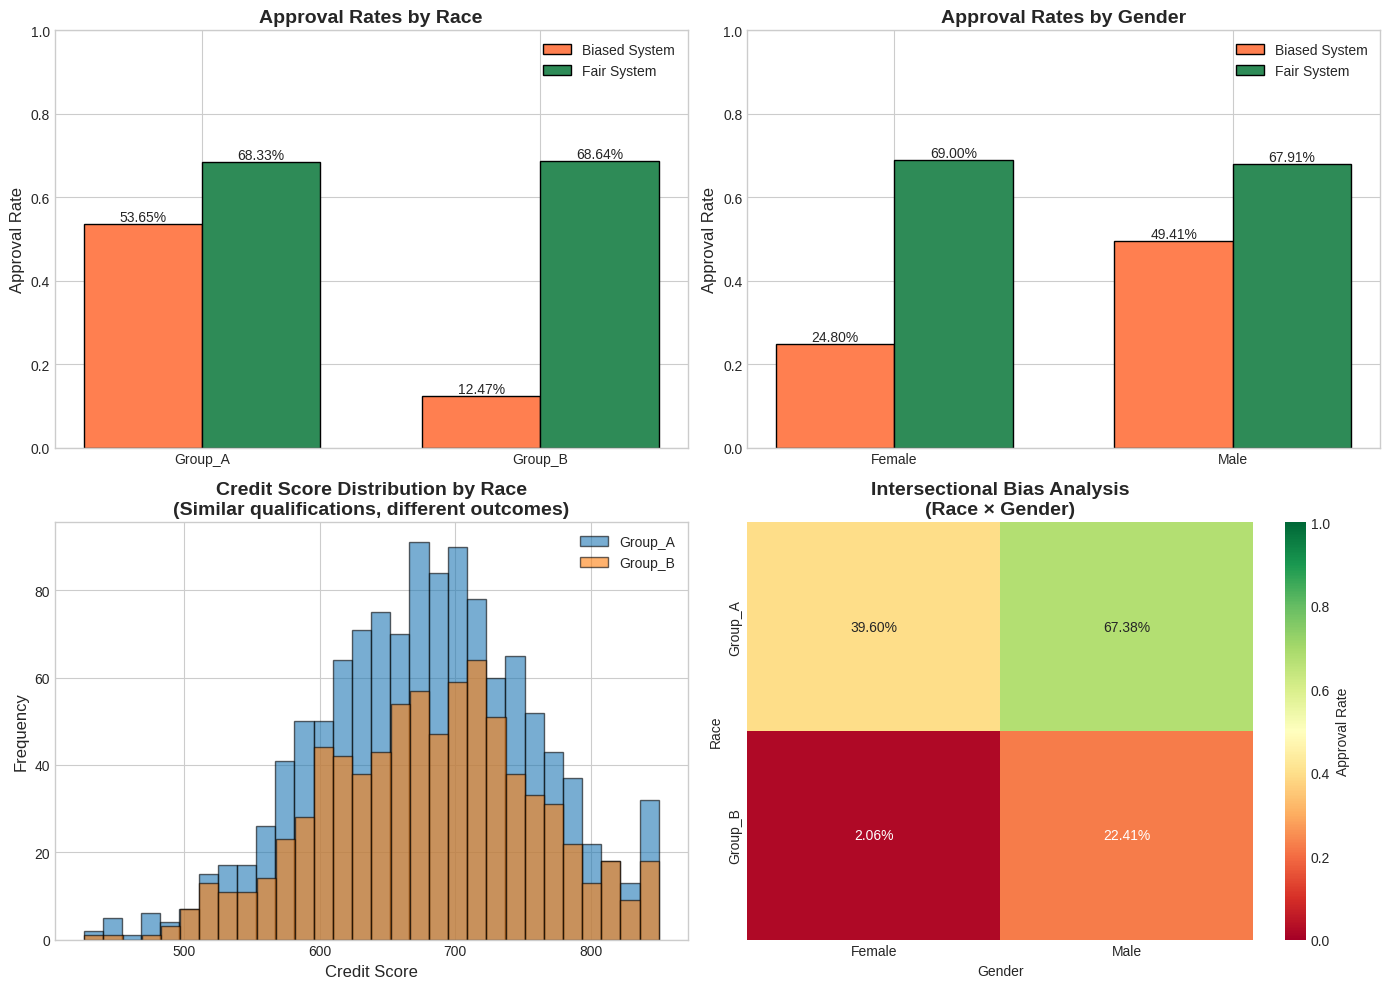

In [4]:
# Visualize the bias in approval rates
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Approval rates by Race
race_rates = df_biased.groupby('race')[['approved_biased', 'approved_fair']].mean()
x = np.arange(len(race_rates))
width = 0.35
bars1 = axes[0, 0].bar(x - width/2, race_rates['approved_biased'], width, label='Biased System', color='coral', edgecolor='black')
bars2 = axes[0, 0].bar(x + width/2, race_rates['approved_fair'], width, label='Fair System', color='seagreen', edgecolor='black')
axes[0, 0].set_ylabel('Approval Rate', fontsize=12)
axes[0, 0].set_title('Approval Rates by Race', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(race_rates.index)
axes[0, 0].legend()
axes[0, 0].set_ylim(0, 1)
for bar in bars1:
    axes[0, 0].annotate(f'{bar.get_height():.2%}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                        ha='center', va='bottom', fontsize=10)
for bar in bars2:
    axes[0, 0].annotate(f'{bar.get_height():.2%}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                        ha='center', va='bottom', fontsize=10)

# Plot 2: Approval rates by Gender
gender_rates = df_biased.groupby('gender')[['approved_biased', 'approved_fair']].mean()
x = np.arange(len(gender_rates))
bars1 = axes[0, 1].bar(x - width/2, gender_rates['approved_biased'], width, label='Biased System', color='coral', edgecolor='black')
bars2 = axes[0, 1].bar(x + width/2, gender_rates['approved_fair'], width, label='Fair System', color='seagreen', edgecolor='black')
axes[0, 1].set_ylabel('Approval Rate', fontsize=12)
axes[0, 1].set_title('Approval Rates by Gender', fontsize=14, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(gender_rates.index)
axes[0, 1].legend()
axes[0, 1].set_ylim(0, 1)
for bar in bars1:
    axes[0, 1].annotate(f'{bar.get_height():.2%}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                        ha='center', va='bottom', fontsize=10)
for bar in bars2:
    axes[0, 1].annotate(f'{bar.get_height():.2%}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                        ha='center', va='bottom', fontsize=10)

# Plot 3: Credit Score Distribution by Race (showing similar qualifications)
for race in df_biased['race'].unique():
    subset = df_biased[df_biased['race'] == race]['credit_score']
    axes[1, 0].hist(subset, bins=30, alpha=0.6, label=race, edgecolor='black')
axes[1, 0].set_xlabel('Credit Score', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Credit Score Distribution by Race\n(Similar qualifications, different outcomes)', fontsize=14, fontweight='bold')
axes[1, 0].legend()

# Plot 4: Intersectional Analysis Heatmap
intersect_pivot = df_biased.groupby(['race', 'gender'])['approved_biased'].mean().unstack()
sns.heatmap(intersect_pivot, annot=True, fmt='.2%', cmap='RdYlGn', ax=axes[1, 1],
            cbar_kws={'label': 'Approval Rate'}, vmin=0, vmax=1)
axes[1, 1].set_title('Intersectional Bias Analysis\n(Race × Gender)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Gender')
axes[1, 1].set_ylabel('Race')

plt.tight_layout()
plt.show()

---
## Part 4: Fairness Metrics

Several metrics help quantify fairness in machine learning systems:

| Metric | Definition | Fair Value |
|--------|------------|------------|
| **Demographic Parity** | Equal approval rates across groups | Ratio ≈ 1.0 |
| **Equalized Odds** | Equal TPR and FPR across groups | Difference ≈ 0 |
| **Disparate Impact** | Ratio of favorable outcomes | Ratio ≥ 0.8 (80% rule) |
| **Predictive Parity** | Equal precision across groups | Difference ≈ 0 |

In [5]:
# Calculate Fairness Metrics
def calculate_fairness_metrics(df, outcome_col, sensitive_col, privileged_group, unprivileged_group):
    """
    Calculate various fairness metrics for binary classification
    """
    priv = df[df[sensitive_col] == privileged_group]
    unpriv = df[df[sensitive_col] == unprivileged_group]

    # Approval rates
    priv_rate = priv[outcome_col].mean()
    unpriv_rate = unpriv[outcome_col].mean()

    metrics = {
        'Privileged Group Rate': priv_rate,
        'Unprivileged Group Rate': unpriv_rate,
        'Demographic Parity Difference': priv_rate - unpriv_rate,
        'Disparate Impact Ratio': unpriv_rate / priv_rate if priv_rate > 0 else 0,
    }

    return metrics

# Calculate metrics for Race
print("=" * 70)
print("FAIRNESS METRICS ANALYSIS")
print("=" * 70)

print("\n🔍 Fairness Metrics by RACE (Biased System):")
race_metrics_biased = calculate_fairness_metrics(df_biased, 'approved_biased', 'race', 'Group_A', 'Group_B')
for metric, value in race_metrics_biased.items():
    print(f"  {metric}: {value:.4f}")

print("\n🔍 Fairness Metrics by RACE (Fair System):")
race_metrics_fair = calculate_fairness_metrics(df_biased, 'approved_fair', 'race', 'Group_A', 'Group_B')
for metric, value in race_metrics_fair.items():
    print(f"  {metric}: {value:.4f}")

print("\n" + "=" * 70)
print("\n🔍 Fairness Metrics by GENDER (Biased System):")
gender_metrics_biased = calculate_fairness_metrics(df_biased, 'approved_biased', 'gender', 'Male', 'Female')
for metric, value in gender_metrics_biased.items():
    print(f"  {metric}: {value:.4f}")

print("\n🔍 Fairness Metrics by GENDER (Fair System):")
gender_metrics_fair = calculate_fairness_metrics(df_biased, 'approved_fair', 'gender', 'Male', 'Female')
for metric, value in gender_metrics_fair.items():
    print(f"  {metric}: {value:.4f}")

# Legal threshold interpretation
print("\n" + "=" * 70)
print("⚖️  LEGAL INTERPRETATION (80% Rule / Four-Fifths Rule)")
print("=" * 70)
di_race = race_metrics_biased['Disparate Impact Ratio']
di_gender = gender_metrics_biased['Disparate Impact Ratio']
print(f"\nRace Disparate Impact: {di_race:.2%}")
print(f"  → {'✅ PASSES' if di_race >= 0.8 else '❌ FAILS'} the 80% rule (threshold: 80%)")
print(f"\nGender Disparate Impact: {di_gender:.2%}")
print(f"  → {'✅ PASSES' if di_gender >= 0.8 else '❌ FAILS'} the 80% rule (threshold: 80%)")

FAIRNESS METRICS ANALYSIS

🔍 Fairness Metrics by RACE (Biased System):
  Privileged Group Rate: 0.5365
  Unprivileged Group Rate: 0.1247
  Demographic Parity Difference: 0.4118
  Disparate Impact Ratio: 0.2324

🔍 Fairness Metrics by RACE (Fair System):
  Privileged Group Rate: 0.6833
  Unprivileged Group Rate: 0.6864
  Demographic Parity Difference: -0.0031
  Disparate Impact Ratio: 1.0046


🔍 Fairness Metrics by GENDER (Biased System):
  Privileged Group Rate: 0.4941
  Unprivileged Group Rate: 0.2480
  Demographic Parity Difference: 0.2461
  Disparate Impact Ratio: 0.5019

🔍 Fairness Metrics by GENDER (Fair System):
  Privileged Group Rate: 0.6791
  Unprivileged Group Rate: 0.6900
  Demographic Parity Difference: -0.0109
  Disparate Impact Ratio: 1.0161

⚖️  LEGAL INTERPRETATION (80% Rule / Four-Fifths Rule)

Race Disparate Impact: 23.24%
  → ❌ FAILS the 80% rule (threshold: 80%)

Gender Disparate Impact: 50.19%
  → ❌ FAILS the 80% rule (threshold: 80%)


---
## Part 5: Training Models on Biased vs Debiased Data

Now we'll compare models trained on:
1. **Biased data** - Using the historically biased labels
2. **Debiased data** - Using fair labels based only on legitimate factors
3. **Blind model** - Removing sensitive attributes from features

In [6]:
# Prepare data for modeling
# Encode categorical variables
df_model = df_biased.copy()
df_model['gender_encoded'] = LabelEncoder().fit_transform(df_model['gender'])
df_model['race_encoded'] = LabelEncoder().fit_transform(df_model['race'])

# Features
feature_cols = ['age', 'income', 'credit_score', 'employment_years', 'loan_amount', 'debt_to_income']
feature_cols_with_sensitive = feature_cols + ['gender_encoded', 'race_encoded']

X_all = df_model[feature_cols_with_sensitive]
X_blind = df_model[feature_cols]  # Without sensitive attributes
y_biased = df_model['approved_biased']
y_fair = df_model['approved_fair']

# Scale features
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)
X_blind_scaled = scaler.fit_transform(X_blind)

# Train-test split
X_all_train, X_all_test, X_blind_train, X_blind_test, y_biased_train, y_biased_test, y_fair_train, y_fair_test = train_test_split(
    X_all_scaled, X_blind_scaled, y_biased, y_fair, test_size=0.3, random_state=42
)

# Keep track of test set demographics for fairness evaluation
_, test_indices = train_test_split(range(len(df_model)), test_size=0.3, random_state=42)
df_test = df_model.iloc[test_indices].copy()

print("Data prepared for modeling:")
print(f"Training samples: {len(X_all_train)}")
print(f"Test samples: {len(X_all_test)}")

Data prepared for modeling:
Training samples: 1400
Test samples: 600


In [7]:
# Train three different models
print("=" * 70)
print("TRAINING MODELS")
print("=" * 70)

# Model 1: Trained on BIASED labels (with sensitive attributes)
model_biased = LogisticRegression(random_state=42, max_iter=1000)
model_biased.fit(X_all_train, y_biased_train)
y_pred_biased = model_biased.predict(X_all_test)
print("\n✅ Model 1: Trained on BIASED data (with sensitive attributes)")

# Model 2: Trained on FAIR labels (debiased)
model_fair = LogisticRegression(random_state=42, max_iter=1000)
model_fair.fit(X_all_train, y_fair_train)
y_pred_fair = model_fair.predict(X_all_test)
print("✅ Model 2: Trained on FAIR/DEBIASED data")

# Model 3: Blind model (no sensitive attributes, trained on biased labels)
model_blind = LogisticRegression(random_state=42, max_iter=1000)
model_blind.fit(X_blind_train, y_biased_train)
y_pred_blind = model_blind.predict(X_blind_test)
print("✅ Model 3: BLIND model (no sensitive attributes)")

# Store predictions in test dataframe
df_test['pred_biased'] = y_pred_biased
df_test['pred_fair'] = y_pred_fair
df_test['pred_blind'] = y_pred_blind

print("\nAll models trained successfully!")

TRAINING MODELS

✅ Model 1: Trained on BIASED data (with sensitive attributes)
✅ Model 2: Trained on FAIR/DEBIASED data
✅ Model 3: BLIND model (no sensitive attributes)

All models trained successfully!


In [8]:
# Compare model performance
print("=" * 70)
print("MODEL PERFORMANCE COMPARISON")
print("=" * 70)

def evaluate_model(y_true, y_pred, model_name):
    return {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred)
    }

# Performance metrics
results = []
results.append(evaluate_model(y_biased_test, y_pred_biased, 'Biased Model'))
results.append(evaluate_model(y_fair_test, y_pred_fair, 'Fair Model'))
results.append(evaluate_model(y_biased_test, y_pred_blind, 'Blind Model'))

df_results = pd.DataFrame(results)
print("\n📊 Performance Metrics (compared to respective ground truth):")
print(df_results.round(4).to_string(index=False))

# Fairness comparison across models
print("\n" + "=" * 70)
print("FAIRNESS COMPARISON ACROSS MODELS (by Race)")
print("=" * 70)

for pred_col, model_name in [('pred_biased', 'Biased Model'),
                              ('pred_fair', 'Fair Model'),
                              ('pred_blind', 'Blind Model')]:
    metrics = calculate_fairness_metrics(df_test, pred_col, 'race', 'Group_A', 'Group_B')
    di = metrics['Disparate Impact Ratio']
    dpd = metrics['Demographic Parity Difference']
    print(f"\n{model_name}:")
    print(f"  Disparate Impact Ratio: {di:.4f} {'✅' if di >= 0.8 else '❌'}")
    print(f"  Demographic Parity Diff: {dpd:.4f}")

MODEL PERFORMANCE COMPARISON

📊 Performance Metrics (compared to respective ground truth):
       Model  Accuracy  Precision  Recall  F1-Score
Biased Model    0.9883     0.9788  0.9914    0.9851
  Fair Model    0.9767     0.9761  0.9903    0.9832
 Blind Model    0.7800     0.7463  0.6567    0.6986

FAIRNESS COMPARISON ACROSS MODELS (by Race)

Biased Model:
  Disparate Impact Ratio: 0.2776 ❌
  Demographic Parity Diff: 0.3969

Fair Model:
  Disparate Impact Ratio: 0.9821 ✅
  Demographic Parity Diff: 0.0126

Blind Model:
  Disparate Impact Ratio: 1.1372 ✅
  Demographic Parity Diff: -0.0445


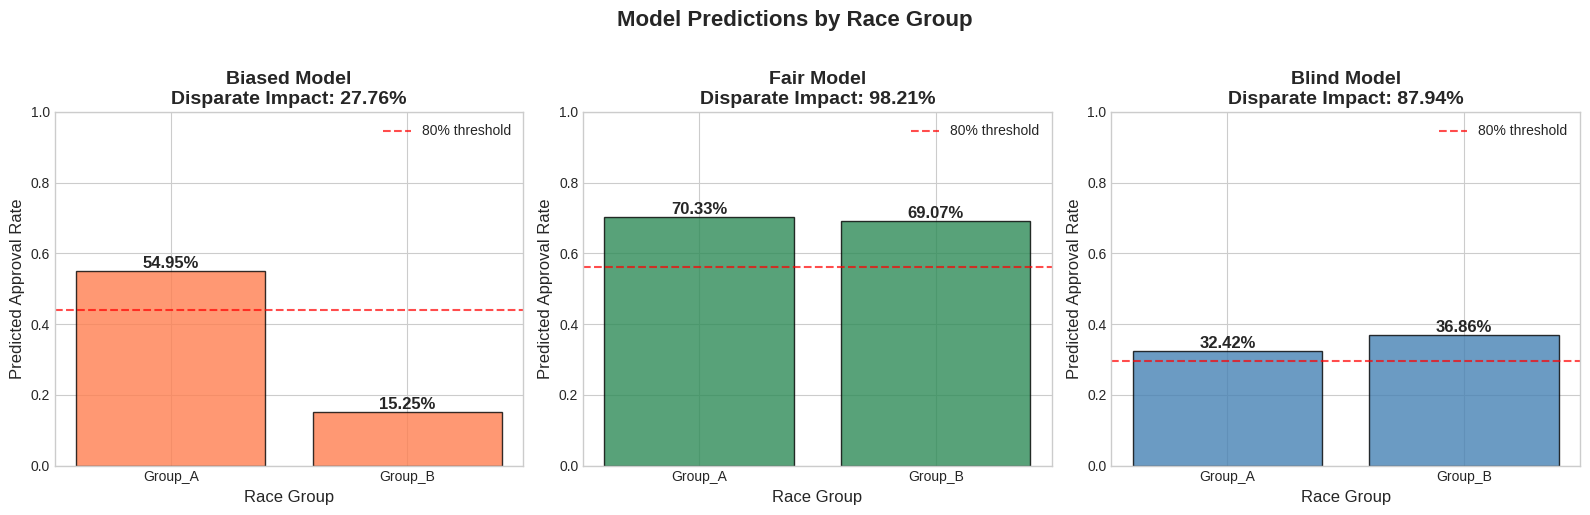

In [9]:
# Visualize model predictions across groups
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

models_data = [
    ('pred_biased', 'Biased Model', 'coral'),
    ('pred_fair', 'Fair Model', 'seagreen'),
    ('pred_blind', 'Blind Model', 'steelblue')
]

for ax, (pred_col, model_name, color) in zip(axes, models_data):
    # Calculate approval rates by race
    rates = df_test.groupby('race')[pred_col].mean()
    bars = ax.bar(rates.index, rates.values, color=color, edgecolor='black', alpha=0.8)

    # Add value labels
    for bar in bars:
        ax.annotate(f'{bar.get_height():.2%}',
                    xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                    ha='center', va='bottom', fontsize=12, fontweight='bold')

    # Calculate and display disparate impact
    di = rates.min() / rates.max()
    ax.set_title(f'{model_name}\nDisparate Impact: {di:.2%}', fontsize=14, fontweight='bold')
    ax.set_ylabel('Predicted Approval Rate', fontsize=12)
    ax.set_xlabel('Race Group', fontsize=12)
    ax.set_ylim(0, 1)
    ax.axhline(y=rates.max() * 0.8, color='red', linestyle='--', alpha=0.7, label='80% threshold')
    ax.legend()

plt.suptitle('Model Predictions by Race Group', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## Part 6: Case Study - COMPAS Recidivism Algorithm

### Background
**COMPAS** (Correctional Offender Management Profiling for Alternative Sanctions) is a risk assessment tool used in US courts to predict the likelihood of a defendant becoming a recidivist (reoffending).

### The ProPublica Investigation (2016)
ProPublica's investigation revealed significant racial disparities:
- **Black defendants** were almost **twice as likely** to be labeled higher risk but not actually re-offend
- **White defendants** were more likely to be labeled low risk but go on to commit future crimes

### Key Findings

In [10]:
# Simulate COMPAS-like scenario to demonstrate the fairness issues
print("=" * 70)
print("CASE STUDY: COMPAS-like Recidivism Prediction Bias")
print("=" * 70)

# Create simulated COMPAS-like data
np.random.seed(42)
n = 1000

compas_data = {
    'race': np.random.choice(['Black', 'White'], n, p=[0.5, 0.5]),
    'age': np.random.randint(18, 65, n),
    'prior_offenses': np.random.poisson(2, n),
    'employed': np.random.choice([0, 1], n, p=[0.3, 0.7]),
}
df_compas = pd.DataFrame(compas_data)

# True recidivism rate (same for both races in this simulation)
base_recidivism_prob = 0.3 + 0.05 * df_compas['prior_offenses'] - 0.1 * df_compas['employed']
df_compas['actual_recidivism'] = (np.random.random(n) < base_recidivism_prob.clip(0, 0.7)).astype(int)

# Biased COMPAS-like predictions (higher risk scores for Black defendants)
compas_bias = np.where(df_compas['race'] == 'Black', 0.15, 0)
biased_score = base_recidivism_prob + compas_bias + np.random.normal(0, 0.1, n)
df_compas['compas_high_risk'] = (biased_score > 0.4).astype(int)

# Calculate error rates by race
print("\n📊 Error Rate Analysis by Race:")
print("-" * 50)

for race in ['Black', 'White']:
    subset = df_compas[df_compas['race'] == race]

    # False Positive Rate: Predicted high risk, but didn't recidivate
    fp = ((subset['compas_high_risk'] == 1) & (subset['actual_recidivism'] == 0)).sum()
    actual_neg = (subset['actual_recidivism'] == 0).sum()
    fpr = fp / actual_neg if actual_neg > 0 else 0

    # False Negative Rate: Predicted low risk, but did recidivate
    fn = ((subset['compas_high_risk'] == 0) & (subset['actual_recidivism'] == 1)).sum()
    actual_pos = (subset['actual_recidivism'] == 1).sum()
    fnr = fn / actual_pos if actual_pos > 0 else 0

    print(f"\n{race} Defendants:")
    print(f"  False Positive Rate: {fpr:.2%} (labeled risky but didn't reoffend)")
    print(f"  False Negative Rate: {fnr:.2%} (labeled safe but did reoffend)")
    print(f"  Predicted High Risk: {subset['compas_high_risk'].mean():.2%}")
    print(f"  Actual Recidivism: {subset['actual_recidivism'].mean():.2%}")

CASE STUDY: COMPAS-like Recidivism Prediction Bias

📊 Error Rate Analysis by Race:
--------------------------------------------------

Black Defendants:
  False Positive Rate: 73.39% (labeled risky but didn't reoffend)
  False Negative Rate: 28.57% (labeled safe but did reoffend)
  Predicted High Risk: 72.76%
  Actual Recidivism: 32.01%

White Defendants:
  False Positive Rate: 24.85% (labeled risky but didn't reoffend)
  False Negative Rate: 64.33% (labeled safe but did reoffend)
  Predicted High Risk: 28.57%
  Actual Recidivism: 34.41%


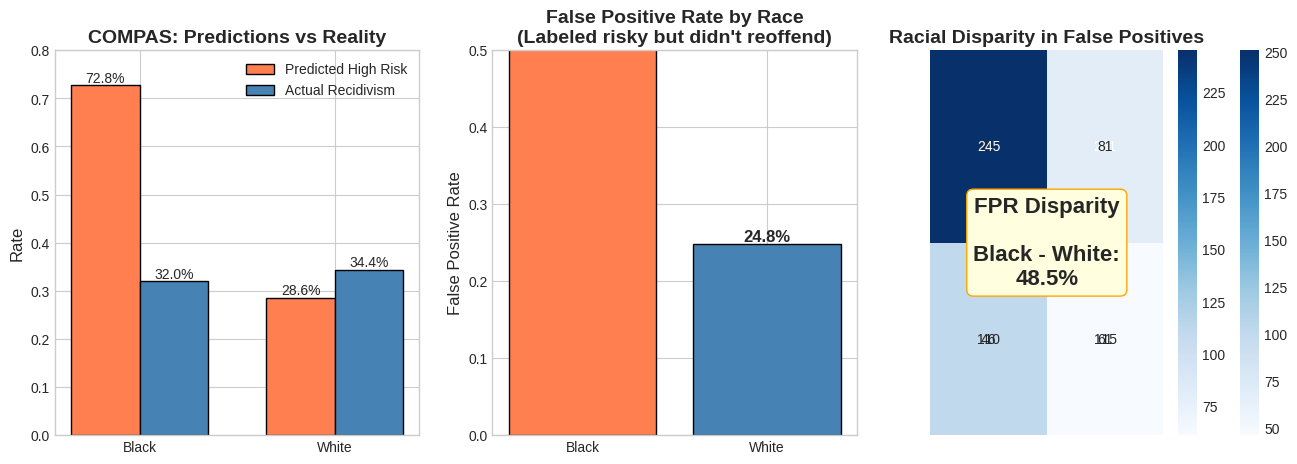

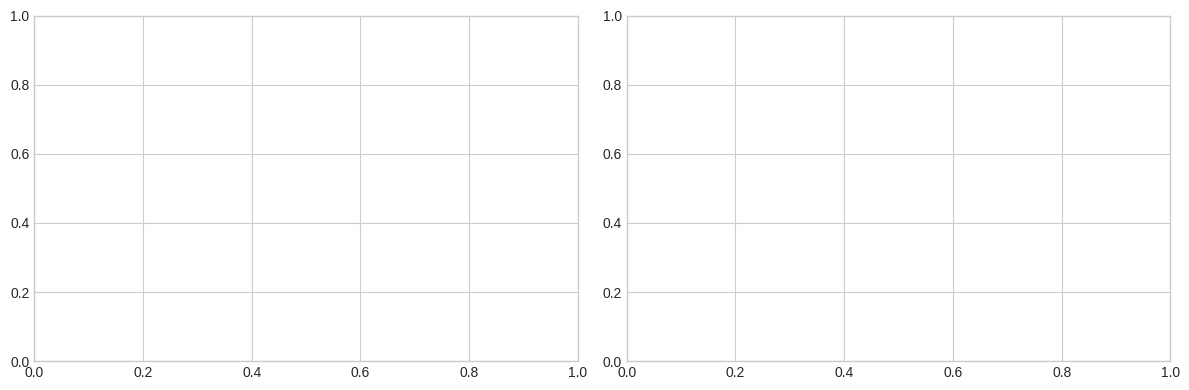


⚠️  KEY INSIGHT: Black defendants have a significantly higher false positive rate,
    meaning they are more likely to be incorrectly labeled as high risk.


In [11]:
# Visualize COMPAS bias
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: Risk predictions vs Actual recidivism by race
metrics_by_race = df_compas.groupby('race').agg({
    'compas_high_risk': 'mean',
    'actual_recidivism': 'mean'
})
x = np.arange(len(metrics_by_race))
width = 0.35
bars1 = axes[0].bar(x - width/2, metrics_by_race['compas_high_risk'], width, label='Predicted High Risk', color='coral', edgecolor='black')
bars2 = axes[0].bar(x + width/2, metrics_by_race['actual_recidivism'], width, label='Actual Recidivism', color='steelblue', edgecolor='black')
axes[0].set_ylabel('Rate', fontsize=12)
axes[0].set_title('COMPAS: Predictions vs Reality', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_by_race.index)
axes[0].legend()
axes[0].set_ylim(0, 0.8)
for bars in [bars1, bars2]:
    for bar in bars:
        axes[0].annotate(f'{bar.get_height():.1%}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                        ha='center', va='bottom', fontsize=10)

# Plot 2: False Positive Rates by Race
fpr_data = []
for race in ['Black', 'White']:
    subset = df_compas[df_compas['race'] == race]
    fp = ((subset['compas_high_risk'] == 1) & (subset['actual_recidivism'] == 0)).sum()
    actual_neg = (subset['actual_recidivism'] == 0).sum()
    fpr_data.append(fp / actual_neg if actual_neg > 0 else 0)

bars = axes[1].bar(['Black', 'White'], fpr_data, color=['coral', 'steelblue'], edgecolor='black')
axes[1].set_ylabel('False Positive Rate', fontsize=12)
axes[1].set_title('False Positive Rate by Race\n(Labeled risky but didn\'t reoffend)', fontsize=14, fontweight='bold')
axes[1].set_ylim(0, 0.5)
for bar in bars:
    axes[1].annotate(f'{bar.get_height():.1%}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                    ha='center', va='bottom', fontsize=12, fontweight='bold')

# Plot 3: Confusion Matrix Comparison
from sklearn.metrics import confusion_matrix
fig_cm, axes_cm = plt.subplots(1, 2, figsize=(12, 4))
for idx, race in enumerate(['Black', 'White']):
    subset = df_compas[df_compas['race'] == race]
    cm = confusion_matrix(subset['actual_recidivism'], subset['compas_high_risk'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[2] if idx == 0 else axes[2],
                xticklabels=['Low Risk', 'High Risk'], yticklabels=['No Recidivism', 'Recidivism'])

# For axes[2], show the disparity
disparity = fpr_data[0] - fpr_data[1]
axes[2].text(0.5, 0.5, f'FPR Disparity\n\nBlack - White:\n{disparity:.1%}',
             ha='center', va='center', fontsize=16, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='lightyellow', edgecolor='orange'),
             transform=axes[2].transAxes)
axes[2].set_title('Racial Disparity in False Positives', fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("\n⚠️  KEY INSIGHT: Black defendants have a significantly higher false positive rate,")
print("    meaning they are more likely to be incorrectly labeled as high risk.")

---
## Part 7: Privacy and Anonymization Techniques

### Common Anonymization Methods
1. **Data Masking**: Replace sensitive values with fictional data
2. **Generalization**: Replace specific values with ranges (e.g., age 25 → 20-30)
3. **K-Anonymity**: Ensure each record is indistinguishable from at least k-1 others
4. **Differential Privacy**: Add noise to protect individual records

In [12]:
# Demonstrate Anonymization Techniques
print("=" * 70)
print("PRIVACY: ANONYMIZATION TECHNIQUES DEMONSTRATION")
print("=" * 70)

# Sample personal data
personal_data = pd.DataFrame({
    'Name': ['John Smith', 'Jane Doe', 'Bob Wilson', 'Alice Brown', 'Charlie Davis'],
    'SSN': ['123-45-6789', '987-65-4321', '456-78-9012', '321-54-9876', '654-32-1098'],
    'Age': [28, 35, 42, 31, 55],
    'Zipcode': ['10001', '10002', '10001', '10003', '10002'],
    'Salary': [75000, 82000, 95000, 68000, 120000],
    'Disease': ['Diabetes', 'None', 'Hypertension', 'None', 'Diabetes']
})

print("\n📋 ORIGINAL DATA (Sensitive!):")
print(personal_data)

# Technique 1: Data Masking
print("\n" + "-" * 50)
print("1️⃣ DATA MASKING (Replace with fictional/partial data):")
masked_data = personal_data.copy()
masked_data['Name'] = ['Person_' + str(i) for i in range(1, len(masked_data) + 1)]
masked_data['SSN'] = masked_data['SSN'].apply(lambda x: 'XXX-XX-' + x[-4:])
print(masked_data)

# Technique 2: Generalization
print("\n" + "-" * 50)
print("2️⃣ GENERALIZATION (Replace with ranges/categories):")
generalized_data = personal_data.copy()
generalized_data['Name'] = '*****'
generalized_data['SSN'] = '*****'
generalized_data['Age'] = pd.cut(generalized_data['Age'], bins=[0, 30, 40, 50, 100], labels=['20-30', '31-40', '41-50', '50+'])
generalized_data['Zipcode'] = generalized_data['Zipcode'].apply(lambda x: x[:3] + '**')
generalized_data['Salary'] = pd.cut(generalized_data['Salary'], bins=[0, 70000, 90000, 150000], labels=['<70K', '70K-90K', '>90K'])
print(generalized_data)

# Technique 3: K-Anonymity explanation
print("\n" + "-" * 50)
print("3️⃣ K-ANONYMITY (Each record indistinguishable from k-1 others):")
k_anon_data = generalized_data.drop(columns=['Name', 'SSN'])
print(k_anon_data)
print("\nK-Anonymity check (k=2):")
group_counts = k_anon_data.groupby(['Age', 'Zipcode']).size()
print(group_counts)
min_k = group_counts.min()
print(f"\nMinimum group size: {min_k}")
print(f"Dataset {'✅ SATISFIES' if min_k >= 2 else '❌ VIOLATES'} 2-anonymity")

PRIVACY: ANONYMIZATION TECHNIQUES DEMONSTRATION

📋 ORIGINAL DATA (Sensitive!):
            Name          SSN  Age Zipcode  Salary       Disease
0     John Smith  123-45-6789   28   10001   75000      Diabetes
1       Jane Doe  987-65-4321   35   10002   82000          None
2     Bob Wilson  456-78-9012   42   10001   95000  Hypertension
3    Alice Brown  321-54-9876   31   10003   68000          None
4  Charlie Davis  654-32-1098   55   10002  120000      Diabetes

--------------------------------------------------
1️⃣ DATA MASKING (Replace with fictional/partial data):
       Name          SSN  Age Zipcode  Salary       Disease
0  Person_1  XXX-XX-6789   28   10001   75000      Diabetes
1  Person_2  XXX-XX-4321   35   10002   82000          None
2  Person_3  XXX-XX-9012   42   10001   95000  Hypertension
3  Person_4  XXX-XX-9876   31   10003   68000          None
4  Person_5  XXX-XX-1098   55   10002  120000      Diabetes

--------------------------------------------------
2️⃣ GENERAL

In [13]:
# Demonstrate Differential Privacy concept
print("=" * 70)
print("4️⃣ DIFFERENTIAL PRIVACY (Adding noise to protect individuals)")
print("=" * 70)

# Original salary statistics
original_mean = personal_data['Salary'].mean()
original_std = personal_data['Salary'].std()

print(f"\nOriginal Statistics:")
print(f"  Mean Salary: ${original_mean:,.2f}")
print(f"  Std Dev: ${original_std:,.2f}")

# Add Laplace noise for differential privacy
def add_laplace_noise(value, sensitivity, epsilon):
    """Add Laplace noise for differential privacy"""
    scale = sensitivity / epsilon
    noise = np.random.laplace(0, scale)
    return value + noise

# Different privacy levels (epsilon)
print("\nNoisy Statistics with Differential Privacy:")
print("-" * 50)

for epsilon in [0.1, 0.5, 1.0, 2.0]:
    noisy_mean = add_laplace_noise(original_mean, 50000, epsilon)  # Sensitivity = max salary range
    privacy_level = "High" if epsilon < 0.5 else "Medium" if epsilon < 1 else "Low"
    print(f"ε = {epsilon} ({privacy_level} privacy): Mean Salary ≈ ${noisy_mean:,.2f}")

print("\n📖 Interpretation:")
print("  - Lower ε (epsilon) = More noise = Stronger privacy = Less accurate")
print("  - Higher ε = Less noise = Weaker privacy = More accurate")
print("  - This is the fundamental privacy-utility tradeoff!")

4️⃣ DIFFERENTIAL PRIVACY (Adding noise to protect individuals)

Original Statistics:
  Mean Salary: $88,000.00
  Std Dev: $20,481.70

Noisy Statistics with Differential Privacy:
--------------------------------------------------
ε = 0.1 (High privacy): Mean Salary ≈ $1,768,577.30
ε = 0.5 (Medium privacy): Mean Salary ≈ $120,033.63
ε = 1.0 (Low privacy): Mean Salary ≈ $31,537.46
ε = 2.0 (Low privacy): Mean Salary ≈ $129,742.81

📖 Interpretation:
  - Lower ε (epsilon) = More noise = Stronger privacy = Less accurate
  - Higher ε = Less noise = Weaker privacy = More accurate
  - This is the fundamental privacy-utility tradeoff!


---
## Part 8: Ethical Guidelines and Best Practices

### Ethical AI Principles

In [14]:
# Ethical AI Checklist
print("=" * 70)
print("✅ ETHICAL AI CHECKLIST FOR DATA MINING PROJECTS")
print("=" * 70)

checklist = """
┌─────────────────────────────────────────────────────────────────────┐
│  📋 PRE-DEVELOPMENT PHASE                                           │
├─────────────────────────────────────────────────────────────────────┤
│  □ Define clear, ethical objectives for the project                 │
│  □ Identify stakeholders who might be affected                      │
│  □ Assess potential for discrimination or harm                      │
│  □ Obtain proper consent for data collection                        │
│  □ Review legal requirements (GDPR, CCPA, HIPAA, etc.)              │
├─────────────────────────────────────────────────────────────────────┤
│  📋 DATA COLLECTION & PREPARATION                                   │
├─────────────────────────────────────────────────────────────────────┤
│  □ Audit data sources for bias                                      │
│  □ Ensure representative sampling across groups                     │
│  □ Document data provenance and limitations                         │
│  □ Apply appropriate anonymization techniques                       │
│  □ Implement secure data storage and access controls                │
├─────────────────────────────────────────────────────────────────────┤
│  📋 MODEL DEVELOPMENT                                               │
├─────────────────────────────────────────────────────────────────────┤
│  □ Test for bias across protected groups                            │
│  □ Calculate fairness metrics (Disparate Impact, etc.)              │
│  □ Consider fairness-accuracy tradeoffs                             │
│  □ Document model decisions and limitations                         │
│  □ Implement model interpretability techniques                      │
├─────────────────────────────────────────────────────────────────────┤
│  📋 DEPLOYMENT & MONITORING                                         │
├─────────────────────────────────────────────────────────────────────┤
│  □ Establish human oversight for critical decisions                 │
│  □ Create appeals process for affected individuals                  │
│  □ Monitor for concept drift and emerging bias                      │
│  □ Regularly audit outcomes across demographic groups               │
│  □ Plan for model updates and retirement                            │
└─────────────────────────────────────────────────────────────────────┘
"""
print(checklist)

✅ ETHICAL AI CHECKLIST FOR DATA MINING PROJECTS

┌─────────────────────────────────────────────────────────────────────┐
│  📋 PRE-DEVELOPMENT PHASE                                           │
├─────────────────────────────────────────────────────────────────────┤
│  □ Define clear, ethical objectives for the project                 │
│  □ Identify stakeholders who might be affected                      │
│  □ Assess potential for discrimination or harm                      │
│  □ Obtain proper consent for data collection                        │
│  □ Review legal requirements (GDPR, CCPA, HIPAA, etc.)              │
├─────────────────────────────────────────────────────────────────────┤
│  📋 DATA COLLECTION & PREPARATION                                   │
├─────────────────────────────────────────────────────────────────────┤
│  □ Audit data sources for bias                                      │
│  □ Ensure representative sampling across groups                     │
│  □ Document dat

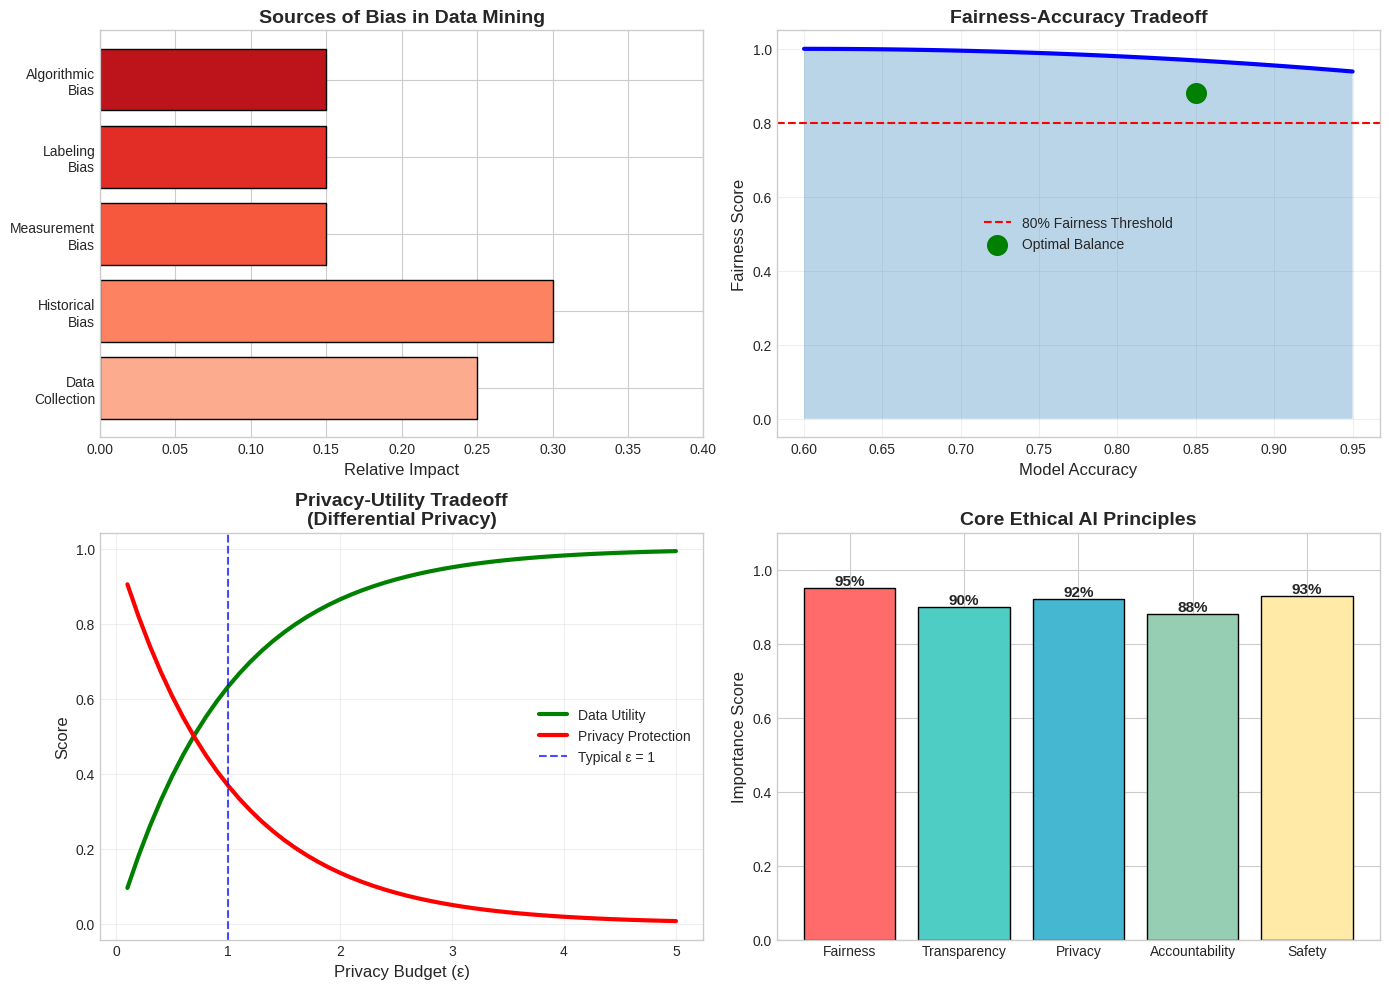

In [15]:
# Summary visualization of key ethical concepts
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Sources of Bias
bias_sources = ['Data\nCollection', 'Historical\nBias', 'Measurement\nBias', 'Labeling\nBias', 'Algorithmic\nBias']
bias_impact = [0.25, 0.30, 0.15, 0.15, 0.15]
colors = plt.cm.Reds(np.linspace(0.3, 0.8, len(bias_sources)))
axes[0, 0].barh(bias_sources, bias_impact, color=colors, edgecolor='black')
axes[0, 0].set_xlabel('Relative Impact', fontsize=12)
axes[0, 0].set_title('Sources of Bias in Data Mining', fontsize=14, fontweight='bold')
axes[0, 0].set_xlim(0, 0.4)

# Plot 2: Fairness vs Accuracy Tradeoff
accuracy_levels = np.linspace(0.6, 0.95, 50)
fairness_levels = 1 - 0.5 * (accuracy_levels - 0.6) ** 2  # Simulated tradeoff curve
axes[0, 1].plot(accuracy_levels, fairness_levels, 'b-', linewidth=3)
axes[0, 1].fill_between(accuracy_levels, fairness_levels, alpha=0.3)
axes[0, 1].axhline(y=0.8, color='red', linestyle='--', label='80% Fairness Threshold')
axes[0, 1].scatter([0.85], [0.88], s=200, c='green', zorder=5, label='Optimal Balance')
axes[0, 1].set_xlabel('Model Accuracy', fontsize=12)
axes[0, 1].set_ylabel('Fairness Score', fontsize=12)
axes[0, 1].set_title('Fairness-Accuracy Tradeoff', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Privacy vs Utility Tradeoff
epsilon_values = np.linspace(0.1, 5, 50)
utility = 1 - np.exp(-epsilon_values)
privacy = np.exp(-epsilon_values)
axes[1, 0].plot(epsilon_values, utility, 'g-', linewidth=3, label='Data Utility')
axes[1, 0].plot(epsilon_values, privacy, 'r-', linewidth=3, label='Privacy Protection')
axes[1, 0].axvline(x=1, color='blue', linestyle='--', alpha=0.7, label='Typical ε = 1')
axes[1, 0].set_xlabel('Privacy Budget (ε)', fontsize=12)
axes[1, 0].set_ylabel('Score', fontsize=12)
axes[1, 0].set_title('Privacy-Utility Tradeoff\n(Differential Privacy)', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Ethical Principles
principles = ['Fairness', 'Transparency', 'Privacy', 'Accountability', 'Safety']
importance = [0.95, 0.90, 0.92, 0.88, 0.93]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
bars = axes[1, 1].bar(principles, importance, color=colors, edgecolor='black')
axes[1, 1].set_ylabel('Importance Score', fontsize=12)
axes[1, 1].set_title('Core Ethical AI Principles', fontsize=14, fontweight='bold')
axes[1, 1].set_ylim(0, 1.1)
for bar in bars:
    axes[1, 1].annotate(f'{bar.get_height():.0%}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                        ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

---
## Conclusions and Key Takeaways

### Summary of Ethical Issues in Data Mining

| Issue | Description | Mitigation |
|-------|-------------|------------|
| **Privacy** | Personal data exposure | Anonymization, encryption, consent |
| **Bias** | Unfair treatment of groups | Fairness metrics, debiasing, diverse data |
| **Transparency** | Black-box decisions | Explainable AI, documentation |
| **Accountability** | No responsibility for harm | Auditing, human oversight |

### Key Fairness Metrics Learned
- **Disparate Impact Ratio**: Should be ≥ 0.8 (80% rule)
- **Demographic Parity**: Equal positive rates across groups
- **Equalized Odds**: Equal error rates across groups

### Case Study Insights (COMPAS)
- Algorithms can perpetuate historical discrimination
- Equal accuracy doesn't mean equal fairness
- Different fairness criteria may conflict with each other

### Lab Outcomes Achieved ✓
1. ✅ Analyzed a biased dataset and demonstrated fairness issues
2. ✅ Compared outputs of models trained on biased vs debiased data
3. ✅ Discussed ethical case studies (COMPAS recidivism algorithm)
4. ✅ Explored privacy-preserving techniques (anonymization, differential privacy)
5. ✅ Understood the importance of ethical design in data mining

---
### Further Reading
- ProPublica's COMPAS Analysis: [Machine Bias](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing)
- EU AI Act and GDPR guidelines
- ACM Code of Ethics for Computing Professionals
- IEEE Ethically Aligned Design framework